# **build models structure**

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 34kB/s 


In [9]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Cropping2D, add, Dropout, Reshape, Activation
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import random

In [3]:
def FCN8_helper(nClasses, input_height, input_width):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    img_input = Input(shape=(input_height, input_width, 3))

    model = vgg16.VGG16( include_top=False, weights='imagenet', input_tensor=img_input, pooling=None, classes=1000)
    assert isinstance(model, Model)

    o = Conv2D( filters=4096, kernel_size=(7, 7), padding="same", activation="relu", name="fc6")(model.output)
    o = Dropout(rate=0.5)(o)
    o = Conv2D( filters=4096, kernel_size=( 1, 1), padding="same", activation="relu", name="fc7")(o)
    o = Dropout(rate=0.5)(o)
    o = Conv2D(filters=nClasses, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal", name="score_fr")(o)

    o = Conv2DTranspose(filters=nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None, name="score2")(o)

    fcn8 = Model(inputs=img_input, outputs=o)
    # mymodel.summary()
    return fcn8

In [4]:
def FCN8(nClasses, input_height, input_width):

    fcn8 = FCN8_helper(nClasses, input_height, input_width)

    # Conv to be applied on Pool4
    skip_con1 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal", name="score_pool4")(fcn8.get_layer("block4_pool").output)
    Summed = add(inputs=[skip_con1, fcn8.output])
    x = Conv2DTranspose(nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None, name="score4")(Summed)

    ###
    skip_con2 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal", name="score_pool3")(fcn8.get_layer("block3_pool").output)
    Summed2 = add(inputs=[skip_con2, x])
    Up = Conv2DTranspose(nClasses, kernel_size=(8, 8), strides=(8, 8), padding="valid", activation=None, name="upsample")(Summed2)

    Up = Reshape((-1, nClasses))(Up)
    Up = Activation("softmax")(Up)

    mymodel = Model(inputs=fcn8.input, outputs=Up)

    return mymodel

# **load batches**

In [16]:
def getImageArr(im):

    img = im.astype(np.float32)

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    return img

one-hot encode the annotation

In [17]:
def getSegmentationArr(seg, nClasses, input_height, input_width):

    seg_labels = np.zeros((input_height, input_width, nClasses))

    for c in range(nClasses):
        seg_labels[:, :, c] = (seg == c).astype(int)

    seg_labels = np.reshape(seg_labels, (-1, nClasses))
    return seg_labels

In [18]:
def imageSegmentationGenerator(images_path, segs_path, batch_size, n_classes, input_height, input_width):

    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = sorted(glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg"))

    segmentations = sorted(glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

    zipped = itertools.cycle(zip(images, segmentations))

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = zipped.__next__()
            im = cv2.imread(im, 1)
            seg = cv2.imread(seg, 0)

            assert im.shape[:2] == seg.shape[:2]
            assert im.shape[0] >= input_height and im.shape[1] >= input_width

            # cut the image to the shape of (h, w ,c)
            xx = random.randint(0, im.shape[0] - input_height)
            yy = random.randint(0, im.shape[1] - input_width)

            im = im[xx:xx + input_height, yy:yy + input_width]
            seg = seg[xx:xx + input_height, yy:yy + input_width]

            X.append(getImageArr(im))
            Y.append(getSegmentationArr( seg, n_classes, input_height, input_width))

        yield np.array(X), np.array(Y)

# **train preprocess: create model and set parameters**

In [ ]:
train_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_train/"
train_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_train/"
train_batch_size = 8
n_classes = 11

epochs = 800

input_height = 320
input_width = 320


val_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_test/"
val_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_test/"
val_batch_size = 8

In [ ]:
model = FCN8(n_classes, input_height, input_width)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adadelta",
    metrics=['acc'])

In [ ]:
G = imageSegmentationGenerator(train_images_path, train_segs_path, train_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)
G_test = imageSegmentationGenerator(val_images_path, val_segs_path, val_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)

# **train 1**

In [ ]:
history = model.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=epochs,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model.save_weights('/content/drive/MyDrive/fcn8_final.h5')

Epoch 1/800
46/46 [==============================] - 11s 236ms/step - loss: 13.4899 - acc: 0.1039 - val_loss: 13.7992 - val_acc: 0.1025
Epoch 2/800
46/46 [==============================] - 11s 233ms/step - loss: 13.3268 - acc: 0.1089 - val_loss: 13.6875 - val_acc: 0.1061
Epoch 3/800
46/46 [==============================] - 11s 235ms/step - loss: 13.1913 - acc: 0.1114 - val_loss: 13.6353 - val_acc: 0.1084
Epoch 4/800
46/46 [==============================] - 11s 233ms/step - loss: 12.9839 - acc: 0.1131 - val_loss: 13.5701 - val_acc: 0.1074
Epoch 5/800
46/46 [==============================] - 11s 234ms/step - loss: 12.8678 - acc: 0.1139 - val_loss: 13.4654 - val_acc: 0.1077
Epoch 6/800
46/46 [==============================] - 11s 233ms/step - loss: 12.7041 - acc: 0.1146 - val_loss: 13.3424 - val_acc: 0.1110
Epoch 7/800
46/46 [==============================] - 11s 233ms/step - loss: 12.5843 - acc: 0.1150 - val_loss: 13.2562 - val_acc: 0.1099
Epoch 8/800
46/46 [=============================

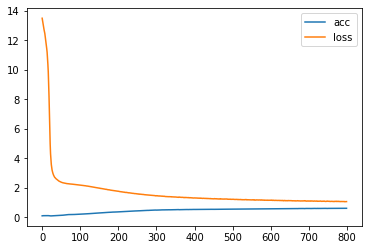

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
x = list(range(len(acc)))
plt.plot(x, acc, label='acc')
plt.plot(x, loss, label='loss')
plt.legend()
plt.show()

Epoch 1/300
46/46 [==============================] - 11s 234ms/step - loss: 1.0732 - acc: 0.6129 - val_loss: 1.2410 - val_acc: 0.5734
Epoch 2/300
46/46 [==============================] - 11s 232ms/step - loss: 1.0675 - acc: 0.6165 - val_loss: 1.2222 - val_acc: 0.5979
Epoch 3/300
46/46 [==============================] - 11s 232ms/step - loss: 1.0650 - acc: 0.6142 - val_loss: 1.1637 - val_acc: 0.6103
Epoch 4/300
46/46 [==============================] - 11s 232ms/step - loss: 1.0706 - acc: 0.6122 - val_loss: 1.1944 - val_acc: 0.5840
Epoch 5/300
46/46 [==============================] - 11s 232ms/step - loss: 1.0623 - acc: 0.6175 - val_loss: 1.2608 - val_acc: 0.5839
Epoch 6/300
46/46 [==============================] - 11s 232ms/step - loss: 1.0682 - acc: 0.6145 - val_loss: 1.2026 - val_acc: 0.6024
Epoch 7/300
46/46 [==============================] - 11s 231ms/step - loss: 1.0588 - acc: 0.6169 - val_loss: 1.1506 - val_acc: 0.5966
Epoch 8/300
46/46 [==============================] - 11s 232ms

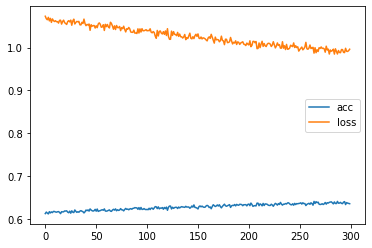

In [ ]:
history = model.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=300,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model.save_weights('/content/drive/MyDrive/fcn8_final2.h5')
acc = history.history['acc']
loss = history.history['loss']
x = list(range(len(acc)))
plt.plot(x, acc, label='acc')
plt.plot(x, loss, label='loss')
plt.legend()
plt.show()

Epoch 1/300
46/46 [==============================] - 11s 232ms/step - loss: 0.9904 - acc: 0.6360 - val_loss: 1.1606 - val_acc: 0.6077
Epoch 2/300
46/46 [==============================] - 11s 231ms/step - loss: 0.9894 - acc: 0.6416 - val_loss: 1.0972 - val_acc: 0.6289
Epoch 3/300
46/46 [==============================] - 11s 231ms/step - loss: 0.9954 - acc: 0.6347 - val_loss: 1.0825 - val_acc: 0.6132
Epoch 4/300
46/46 [==============================] - 11s 231ms/step - loss: 0.9846 - acc: 0.6393 - val_loss: 1.1518 - val_acc: 0.5961
Epoch 5/300
46/46 [==============================] - 11s 231ms/step - loss: 0.9881 - acc: 0.6409 - val_loss: 1.1167 - val_acc: 0.6414
Epoch 6/300
46/46 [==============================] - 11s 230ms/step - loss: 0.9858 - acc: 0.6419 - val_loss: 1.0751 - val_acc: 0.6223
Epoch 7/300
46/46 [==============================] - 11s 231ms/step - loss: 0.9918 - acc: 0.6394 - val_loss: 1.1155 - val_acc: 0.6016
Epoch 8/300
46/46 [==============================] - 11s 231ms

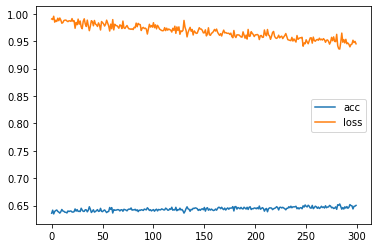

In [ ]:
history = model.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=300,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model.save_weights('/content/drive/MyDrive/fcn8_final3.h5')
acc = history.history['acc']
loss = history.history['loss']
x = list(range(len(acc)))
plt.plot(x, acc, label='acc')
plt.plot(x, loss, label='loss')
plt.legend()
plt.show()

# **last model seems to fall into a local minima, and can't get out, try to train a new model again using adam.**

In [6]:
train_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_train/"
train_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_train/"
train_batch_size = 8
n_classes = 11

epochs = 800

input_height = 320
input_width = 320


val_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_test/"
val_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_test/"
val_batch_size = 8


In [ ]:
model_adam = FCN8(n_classes, input_height, input_width)

In [ ]:
model_adam.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['acc'])

In [ ]:
G = imageSegmentationGenerator(train_images_path, train_segs_path, train_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)

G_test = imageSegmentationGenerator(val_images_path, val_segs_path, val_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)

In [ ]:
history = model_adam.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=epochs,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model_adam.save_weights('/content/drive/MyDrive/fcn8_adam_final.h5')

Epoch 1/800
46/46 [==============================] - 11s 237ms/step - loss: 10.2009 - acc: 0.1943 - val_loss: 2.2691 - val_acc: 0.2235
Epoch 2/800
46/46 [==============================] - 11s 231ms/step - loss: 1.8986 - acc: 0.2802 - val_loss: 1.9079 - val_acc: 0.2975
Epoch 3/800
46/46 [==============================] - 11s 229ms/step - loss: 1.7117 - acc: 0.3086 - val_loss: 1.9116 - val_acc: 0.3053
Epoch 4/800
46/46 [==============================] - 11s 229ms/step - loss: 1.6371 - acc: 0.3361 - val_loss: 1.8507 - val_acc: 0.3128
Epoch 5/800
46/46 [==============================] - 11s 229ms/step - loss: 1.5974 - acc: 0.3623 - val_loss: 1.7639 - val_acc: 0.3534
Epoch 6/800
46/46 [==============================] - 10s 228ms/step - loss: 1.5679 - acc: 0.3818 - val_loss: 1.7428 - val_acc: 0.3810
Epoch 7/800
46/46 [==============================] - 11s 229ms/step - loss: 1.5402 - acc: 0.3847 - val_loss: 1.7723 - val_acc: 0.3541
Epoch 8/800
46/46 [==============================] - 11s 229m

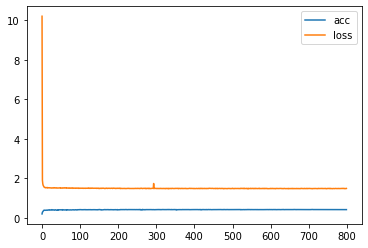

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
x = list(range(len(acc)))
plt.plot(x, acc, label='acc')
plt.plot(x, loss, label='loss')
plt.legend()
plt.show()

# **predict**

In [7]:
n_classes = 11
input_height = 320
input_width = 320
predictor = FCN8(n_classes, input_height, input_width)
predictor.load_weights('/content/drive/MyDrive/fcn8_final3.h5')
images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_test/"
segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_test/"

58892288/58889256 [==============================] - 1s 0us/step


In [10]:
colors = [ (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n_classes)]

In [11]:
def label2color(colors, n_classes, seg):
    """
    inputs: 
            colors: a map from class_label to a specific color
            n_classes:
            seg: predict result: (b, h * w, n_classes)
    output:
        seg_color: (b, h * w, 3)
    """
    seg_color = np.zeros((seg.shape[0], seg.shape[1], 3))
    for c in range(n_classes):
        seg_color[:, :, 0] += ((seg == c) * (colors[c][0])).astype('uint8')
        seg_color[:, :, 1] += ((seg == c) * (colors[c][1])).astype('uint8')
        seg_color[:, :, 2] += ((seg == c) * (colors[c][2])).astype('uint8')
    seg_color = seg_color.astype(np.uint8)
    return seg_color

In [12]:
def getcenteroffset(shape, input_height, input_width):
    short_edge = min(shape[:2])
    xx = int((shape[0] - short_edge) / 2)
    yy = int((shape[1] - short_edge) / 2)
    return xx, yy

In [13]:
images = sorted(glob.glob( images_path + "*.jpg") + glob.glob( images_path + "*.png") + glob.glob( images_path + "*.jpeg"))
segmentations = sorted(glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

In [14]:
from google.colab.patches import cv2_imshow

In [19]:
for i, (imgName, segName) in enumerate(zip(images, segmentations)):

    print("%d/%d %s" % (i + 1, len(images), imgName))

    im = cv2.imread(imgName, 1)
    xx, yy = getcenteroffset(im.shape, input_height, input_width)
    im = im[xx:xx + input_height, yy:yy + input_width, :]

    seg = cv2.imread(segName, 0)
    seg = seg[xx:xx + input_height, yy:yy + input_width]

    pr = predictor.predict(np.expand_dims(getImageArr(im), 0))[0]
    pr = pr.reshape((input_height, input_width, n_classes)).argmax(axis=2)

    cv2_imshow(im)
    cv2_imshow(label2color(colors, n_classes, pr))
    cv2_imshow(label2color(colors, n_classes, seg))

    cv2.waitKey()

Output hidden; open in https://colab.research.google.com to view.

# **previous training result using adam**

In [ ]:
for i, (imgName, segName) in enumerate(zip(images, segmentations)):

    print("%d/%d %s" % (i + 1, len(images), imgName))

    im = cv2.imread(imgName, 1)
    xx, yy = getcenteroffset(im.shape, input_height, input_width)
    im = im[xx:xx + input_height, yy:yy + input_width, :]

    seg = cv2.imread(segName, 0)
    seg = seg[xx:xx + input_height, yy:yy + input_width]

    pr = model.predict(np.expand_dims(getImageArr(im), 0))[0]
    pr = pr.reshape((input_height, input_width, n_classes)).argmax(axis=2)

    cv2_imshow(im)
    cv2_imshow(label2color(colors, n_classes, pr))
    cv2_imshow(label2color(colors, n_classes, seg))

    cv2.waitKey()

Output hidden; open in https://colab.research.google.com to view.